In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
# import wandb # This is optional 
# wandb.login(host = "https://genentech.wandb.io" )

/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load pre-trained model 

In [2]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/DNA-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    checkpoint_path = '../../save_models/ATAC/Hepg2_10class_V1/_2024.09.11_03.01.28/diffusion_epoch=479-average-loss=0.285.ckpt'
    time_schedule = 'artifacts/DNA-dataset:v0/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:6"

In [3]:
# Load Reward model
from grelu.lightning import LightningModel

classifier = LightningModel.load_from_checkpoint("experiment/lightning_logs/4l86okh7/checkpoints/epoch=3-step=1844.ckpt")
classifier.eval()
classifier.to(DEVICE)

/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TF_GAMMAS = torch.load(s

LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [4]:
original_model = lightning_dif.load_from_checkpoint(
        checkpoint_path=config.checkpoint_path, 
        weight_file=config.diffusion_weights_file, 
        time_schedule=config.time_schedule, 
        augment=False,
        continuous=False,
        all_class_number=10,
    )

original_model = original_model.model
original_model.cuda(device = DEVICE)

/data/yulai/projects/RLfinetuning_Diffusion_Bioseq/tutorials/Human-enhancer/../../src/model/lightning_model_diffusion.py:29: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


AugmentedScoreNet_Conditional(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), 

# Evaluation 

In [5]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler
strength = 3
batch_size = 512

conditions_10class = [torch.tensor([i,] * batch_size, device=DEVICE, dtype=torch.long) for i in range(10)]

allsamples_original_conditions = [[] for _ in range(10)]

all_sknsh_classes = [[] for _ in range(10)]
all_hepg2_classes = [[] for _ in range(10)]

# Original model needs to be in evaluation mode
original_model.eval()

for class_num in range(10):
    for _ in range(8):
        samples = sampler(original_model,
                        (200, 4), 
                        existing_condition = conditions_10class[class_num],
                        class_number=10,
                        strength=strength,
                        batch_size=batch_size,
                        max_time=4.0,
                        min_time=1/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced=True,
                        device=DEVICE,
                        augment=False
                        ).cpu().detach().numpy()
        
        all_hepg2_classes[class_num].append(conditions_10class[class_num])
        
        samples_tensor = torch.tensor(samples, device=DEVICE)
        samples_onehot = (samples_tensor > 0.5) * torch.ones_like(samples_tensor)
        allsamples_original_conditions[class_num].append(samples_onehot.cpu().detach().numpy())
        
        samples_onehot = torch.permute(samples_onehot, (0, 2, 1)).to(DEVICE)           # # (batch, 200, 4) -> (batch, 10)
        probabilities = classifier(samples_onehot).squeeze(-1).cpu().detach().numpy()
        all_sknsh_classes[class_num].append(np.argmax(probabilities, axis=1))

In [6]:
# Concatenate samples for each class
allsamples_conditions = [np.concatenate(allsamples_original_conditions[i], axis=0) for i in range(10)]
allsamples_hepg2 = [np.concatenate([tensor.cpu().numpy() for tensor in all_hepg2_classes[i]], axis=0) for i in range(10)]
allsamples_sknsh = [np.concatenate(all_sknsh_classes[i], axis=0) for i in range(10)]

In [7]:
small_data_x = np.concatenate(allsamples_conditions, axis=0)
hepg2_discretized_indices = np.concatenate(allsamples_hepg2, axis=0)
sknsh_discretized_indices = np.concatenate(allsamples_sknsh, axis=0)

print(hepg2_discretized_indices[:10])
print(sknsh_discretized_indices[:10])

print(len(hepg2_discretized_indices))
print(small_data_x.shape)

[0 0 0 0 0 0 0 0 0 0]
[6 8 5 1 3 5 9 1 1 2]
40960
(40960, 200, 4)


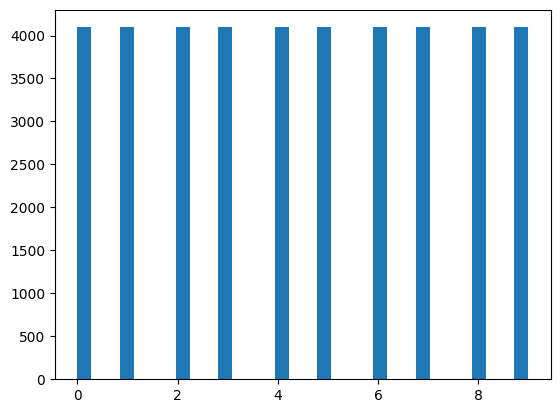

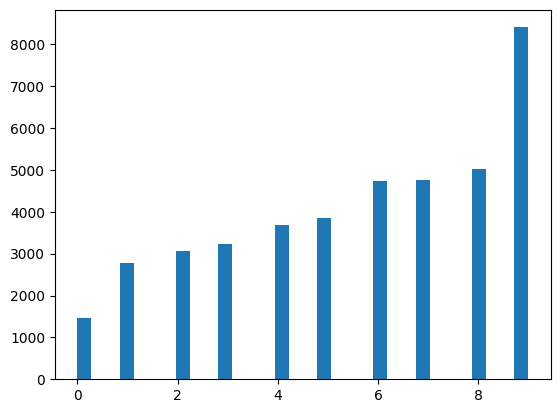

In [10]:
plt.hist(hepg2_discretized_indices, bins='auto')
plt.show()
plt.hist(sknsh_discretized_indices, bins='auto')
plt.show()

In [9]:
np.savez_compressed("./artifacts/DNA-dataset:v0/y_HepG2_10class_atac_clsfree_guidance=3.npz", x = small_data_x, y = hepg2_discretized_indices)
np.savez_compressed("./artifacts/DNA-dataset:v0/y_SKNSH_10class_atac_clsfree_guidance=3.npz", x = small_data_x, y = sknsh_discretized_indices)